<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/cluster_max_diameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clustering of Volcanoes and Earthquakes 🌋🌍

Алгоритм:
Во внешнем цикле меняется не максимальное расстояние между двумя элементами кластера, а максимальный разрешённый диаметр кластера.

In [48]:
# Input parameters
LANGUAGE = 'ru'  # 'en' or 'ru'

f_volcano = "volcanoes_2025.csv"
f_earthquake = "earthquakes_2025.csv"

# --- New clustering by max diameter ---
#cluster_diameter_max_list = list(range(10, 250, 10)) + [127]
#cluster_diameter_max_list = list(range(10, 120, 10)) + [127] + list(range(130, 250, 10))
distances_max_list = list(range(10, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 130, 10))

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(30, 150, 10)
distances_max_list = list(range(30, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 150, 10)) # slow real
# distances_max_list = list(range(30, 80, 20)) + list(range(80, 100, 5)) + list(range(100, 150, 20)) # fast

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
#distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[30, 40, 50, 60, 70, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 110, 120, 130, 140]


In [49]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
import folium
#from mpl_toolkits.axes_grid1 import host_subplot

#import mpl_toolkits.axisartist as AA
#from   mpl_toolkits.axisartist import Subplot as AA

from sklearn.metrics.pairwise import haversine_distances



# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_earthquake

#!head -n 3 $f_volcano
#!head -n 3 $f_earthquake

--2025-05-02 22:06:41--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/volcanoes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168392 (164K) [text/plain]
Saving to: ‘volcanoes_2025.csv.9’

volcanoes_2025.csv. 100%[===================>] 164.45K  --.-KB/s    in 0.1s    

2025-05-02 22:06:42 (1.17 MB/s) - ‘volcanoes_2025.csv.9’ saved [168392/168392]

--2025-05-02 22:06:42--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/earthquakes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

# 📏 Computing the Maximum Diameter of a Group

In [50]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

D= 10 | Groups: 3103 | AvgSize:  1.35 | MaxSize:  91 | VolcanoOnly: 1125 | EarthquakeOnly: 1956 | Mixed:  22
D= 20 | Groups: 2663 | AvgSize:  1.57 | MaxSize: 312 | VolcanoOnly: 855 | EarthquakeOnly: 1746 | Mixed:  62
D= 30 | Groups: 2307 | AvgSize:  1.81 | MaxSize: 313 | VolcanoOnly: 673 | EarthquakeOnly: 1552 | Mixed:  82
D= 40 | Groups: 2028 | AvgSize:  2.06 | MaxSize: 313 | VolcanoOnly: 561 | EarthquakeOnly: 1369 | Mixed:  98
D= 50 | Groups: 1763 | AvgSize:  2.37 | MaxSize: 313 | VolcanoOnly: 458 | EarthquakeOnly: 1195 | Mixed: 110
D= 60 | Groups: 1539 | AvgSize:  2.71 | MaxSize: 313 | VolcanoOnly: 385 | EarthquakeOnly: 1044 | Mixed: 110
D= 70 | Groups: 1358 | AvgSize:  3.07 | MaxSize: 313 | VolcanoOnly: 331 | EarthquakeOnly: 920 | Mixed: 107
D= 80 | Groups: 1213 | AvgSize:  3.44 | MaxSize: 313 | VolcanoOnly: 296 | EarthquakeOnly: 813 | Mixed: 104
D= 90 | Groups: 1077 | AvgSize:  3.88 | MaxSize: 313 | VolcanoOnly: 251 | EarthquakeOnly: 717 | Mixed: 109
D=100 | Groups:  956 | AvgSize

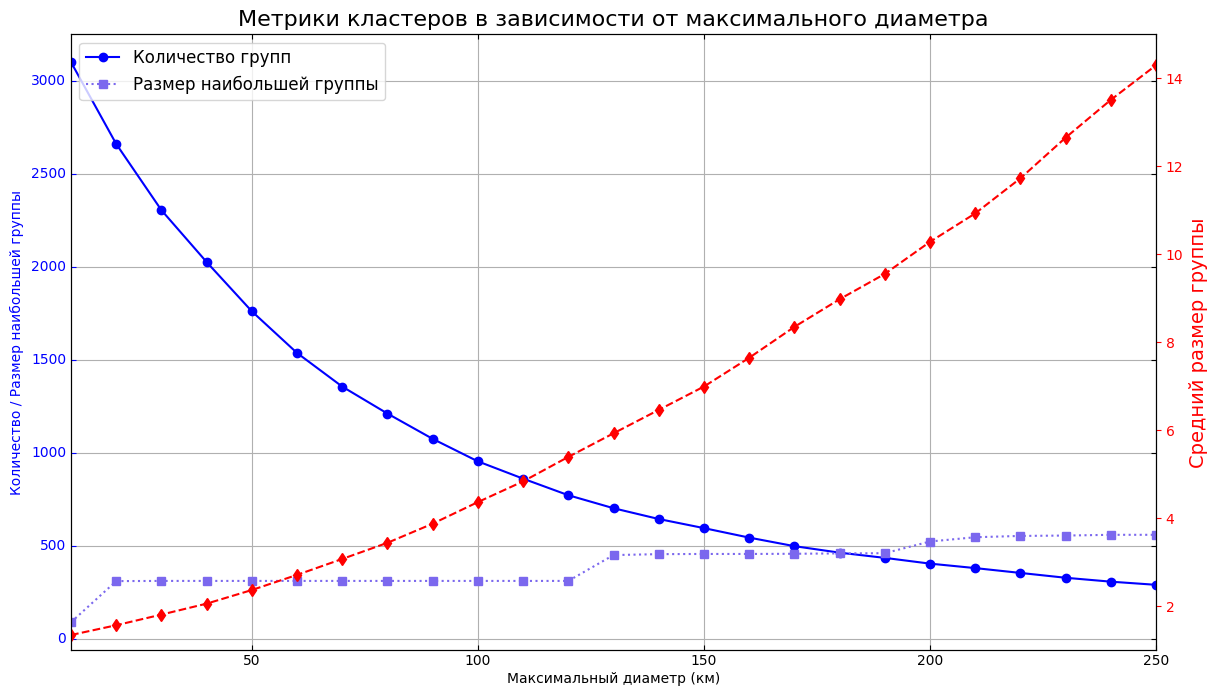

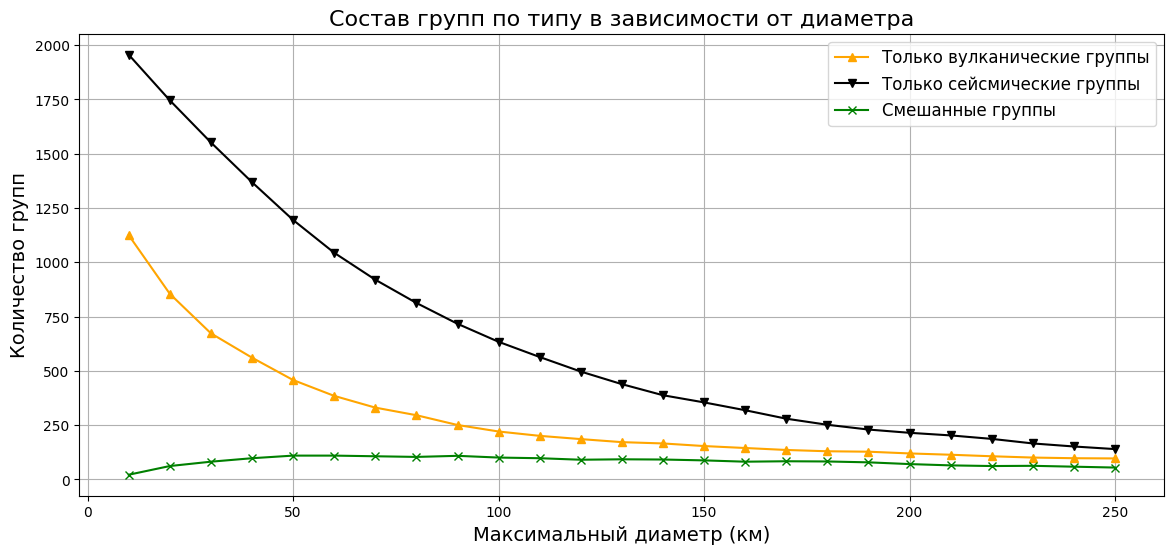

In [51]:
# --- Language translation: 'en' or 'ru' ---
def tr(en_text: str, ru_text: str) -> str:
    """Simple translator function. Returns text based on current LANGUAGE setting."""
    return ru_text if LANGUAGE == 'ru' else en_text

# --- Load volcano and earthquake coordinates ---

def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

with open(f_volcano, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

with open(f_earthquake, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

from sklearn.metrics.pairwise import haversine_distances as sklearn_haversine
from sklearn.neighbors import KDTree

def haversine_matrix(coords):
    return sklearn_haversine(np.radians(coords)) * 6371.0

def compute_group_diameter(coords):
    if len(coords) < 2:
        return 0
    dist_matrix = haversine_matrix(coords)
    return np.max(dist_matrix)

from collections import defaultdict

diameter_limits = list(range(10, 251, 10))
groups_count_list = []
average_group_size_list = []
largest_group_size_list = []
volcano_only_count = []
earthquake_only_count = []
mixed_group_count = []

all_clusters_by_d = {}

coords_array = np.radians(np.array(all_coords))
kdtree = KDTree(coords_array, metric='euclidean')

for d_max in diameter_limits:
    G = nx.Graph()
    for idx, coord in enumerate(all_coords):
        G.add_node(idx, pos=coord, type=types[idx])

    radius_rad = d_max / 6371.0
    pairs = kdtree.query_radius(coords_array, r=radius_rad, return_distance=False)

    for i, neighbors in enumerate(pairs):
        for j in neighbors:
            if i < j:
                G.add_edge(i, j)

    connected_components = list(nx.connected_components(G))
    all_clusters_by_d[d_max] = connected_components

    group_sizes = [len(group) for group in connected_components]
    groups_count_list.append(len(group_sizes))
    average_group_size_list.append(np.mean(group_sizes) if group_sizes else 0)
    largest_group_size_list.append(np.max(group_sizes) if group_sizes else 0)

    volcano_only = 0
    earthquake_only = 0
    mixed = 0

    for group in connected_components:
        group_types = set(types[idx] for idx in group)
        if group_types == {'volcano'}:
            volcano_only += 1
        elif group_types == {'earthquake'}:
            earthquake_only += 1
        else:
            mixed += 1

    volcano_only_count.append(volcano_only)
    earthquake_only_count.append(earthquake_only)
    mixed_group_count.append(mixed)

    print(f"D={d_max:3d} | Groups: {len(group_sizes):4d} | AvgSize: {average_group_size_list[-1]:5.2f} | MaxSize: {largest_group_size_list[-1]:3d} | VolcanoOnly: {volcano_only:3d} | EarthquakeOnly: {earthquake_only:3d} | Mixed: {mixed:3d}")

# --- Plot the results with right Y-axis for average group size ---

import mpl_toolkits.axisartist as AA
from mpl_toolkits.axisartist import Subplot as AA_Subplot

fig = plt.figure(figsize=(14, 8))
host = AA_Subplot(fig, 111)
fig.add_subplot(host)

par1 = host.twinx()  # Right Y-axis

host.plot(diameter_limits, groups_count_list, marker='o', label=tr("Number of Groups", "Количество групп"), color='blue')
host.plot(diameter_limits, largest_group_size_list, marker='s', linestyle=':', label=tr("Largest Group Size", "Размер наибольшей группы"), color='mediumslateblue')
par1.plot(diameter_limits, average_group_size_list, marker='d', linestyle='--', label=tr("Average Group Size", "Средний размер группы"), color='red')

host.set_xlabel(tr("Maximum Diameter (km)", "Максимальный диаметр (км)"), fontsize=14)
host.set_ylabel(tr("Group Count / Largest Size", "Количество / Размер наибольшей группы"), fontsize=14)
par1.set_ylabel(tr("Average Group Size", "Средний размер группы"), fontsize=14)

host.axis["left"].label.set_color("blue")
host.axis["left"].major_ticks.set_color("blue")
host.axis["left"].major_ticklabels.set_color("blue")

par1.tick_params(axis='y', colors='red')
par1.yaxis.label.set_color("red")

par1.set_ylim(1, 15)
host.set_xlim(min(diameter_limits), max(diameter_limits))

host.legend(loc="upper left", fontsize=12)
host.set_title(tr("Cluster Metrics vs Maximum Diameter", "Метрики кластеров в зависимости от максимального диаметра"), fontsize=16)
host.grid(True)
plt.show()

# --- Plot cluster type composition ---

plt.figure(figsize=(14, 6))
plt.plot(diameter_limits, volcano_only_count, marker='^', label=tr("Volcano-only Groups", "Только вулканические группы"), color='orange')
plt.plot(diameter_limits, earthquake_only_count, marker='v', label=tr("Earthquake-only Groups", "Только сейсмические группы"), color='black')
plt.plot(diameter_limits, mixed_group_count, marker='x', label=tr("Mixed Groups", "Смешанные группы"), color='green')

plt.xlabel(tr("Maximum Diameter (km)", "Максимальный диаметр (км)"), fontsize=14)
plt.ylabel(tr("Number of Groups", "Количество групп"), fontsize=14)
plt.legend(fontsize=12)
plt.title(tr("Composition of Groups by Type vs Diameter", "Состав групп по типу в зависимости от диаметра"), fontsize=16)
plt.grid(True)
plt.show()

# --- Draw map for d_max = 120 ---

import folium
from folium import plugins

m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB positron')

if 120 in all_clusters_by_d:
    for group in all_clusters_by_d[120]:
        group_coords = [all_coords[idx] for idx in group]
        group_types = [types[idx] for idx in group]

        # Add points
        for coord, t in zip(group_coords, group_types):
            folium.CircleMarker(location=coord,
                                radius=4,
                                color='red' if t == 'volcano' else 'black',
                                fill=True,
                                fill_opacity=1).add_to(m)

        # Add approximate bounding circle
        if len(group_coords) > 1:
            center_lat = np.mean([c[0] for c in group_coords])
            center_lon = np.mean([c[1] for c in group_coords])
            diameter_km = compute_group_diameter(group_coords)
            folium.Circle(location=(center_lat, center_lon),
                          radius=(diameter_km * 500),  # ~ half diameter in meters
                          color='gray',
                          fill=False,
                          weight=1,
                          dash_array='5').add_to(m)

m